In [30]:
import torch 
import torch.nn as nn
from torchdiffeq import odeint as odeint
import pylab as plt
from torch.utils.data import Dataset, DataLoader
from typing import Callable, List, Tuple, Union, Optional
from pathlib import Path  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
class LotkaVolterra(nn.Module):
    """ 
     The Lotka-Volterra equations are a pair of first-order, non-linear, differential equations
     describing the dynamics of two species interacting in a predator-prey relationship.
    """
    def __init__(self,
                 alpha: float = 3.0, # The alpha parameter of the Lotka-Volterra system
                 beta: float =  0.6,  # The beta parameter of the Lotka-Volterra system
                 gamma: float = 0.5, # The delta parameter of the Lotka-Volterra system
                 delta: float = 4.0  # The gamma parameter of the Lotka-Volterra system
                 ) -> None:
        super().__init__()
        self.model_params = torch.nn.Parameter(torch.tensor([alpha, beta, delta, gamma]))
        
        
    def forward(self, t, state):
        x = state[...,0]      #variables are part of vector array u 
        y = state[...,1]
        sol = torch.zeros_like(state)
        
        #coefficients are part of tensor model_params
        alpha, beta, delta, gamma = self.model_params    
        sol[...,0] = alpha*x - beta*x*y
        sol[...,1] = -delta*y + gamma*x*y
        return sol

Dataset length: 2


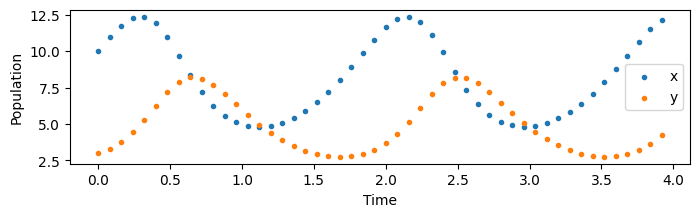

In [32]:
lv_model = LotkaVolterra().to(device)
ts = torch.arange(0.0, 4.0, .08, device=device)
y0 = torch.tensor([10., 3.], device=device)
y_true = odeint(lv_model, y0, ts, method='dopri5').detach()
print(f'Dataset length: {y_true.shape[1]}')

plt.figure(figsize=(8, 2))
plt.scatter(ts.cpu().detach().numpy(), y_true[:,0].cpu().detach().numpy(), label='x', marker='.')
plt.scatter(ts.cpu().detach().numpy(), y_true[:,1].cpu().detach().numpy(), label='y', marker='.')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

In [33]:
# model = LotkaVolterra(alpha=1.0, beta=1.5, gamma=0.8, delta=3.0).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.MSELoss()

# for epoch in range(100):
#     optimizer.zero_grad()
#     y_pred = odeint(model, y0, ts, method='dopri5')
#     loss = criterion(y_pred, y_true)
#     loss.backward()
#     optimizer.step()
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss {loss.item()}')

# # Get model parameters values
# alpha, beta, delta, gamma = model.model_params
# print(f'alpha: {alpha:.2f}, beta: {beta:.2f}, delta: {delta:.2f}, gamma: {gamma:.2f}')

In [34]:
class NeuralDiffeq(nn.Module):
    """
        Basic Neural ODE model
    """
    def __init__(self, dim: int = 2) -> None:
        super().__init__()
        self.func = nn.Sequential(
            nn.Linear(dim, 10),
            nn.Tanh(),
            nn.Linear(10, dim)
        )

    def forward(self, t, state):
        return self.func(state)

# Define the model, optimizer and loss function    
model = NeuralDiffeq(dim=2).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [35]:
total_loss = []
for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = odeint(model, y0, ts, method='euler')
    loss = criterion(y_pred, y_true)
    loss.backward()
    total_loss.append(loss.item())  
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

Epoch 0, Loss 15.083123207092285
Epoch 10, Loss 5.777915000915527
Epoch 20, Loss 5.481158256530762
Epoch 30, Loss 5.347744464874268
Epoch 40, Loss 5.225761413574219
Epoch 50, Loss 5.1511077880859375
Epoch 60, Loss 5.098407745361328
Epoch 70, Loss 5.051264762878418
Epoch 80, Loss 5.013247013092041
Epoch 90, Loss 4.988689422607422
Epoch 100, Loss 4.970925331115723
Epoch 110, Loss 4.957441329956055
Epoch 120, Loss 4.946953773498535
Epoch 130, Loss 4.938663005828857
Epoch 140, Loss 4.932021617889404
Epoch 150, Loss 4.92664098739624
Epoch 160, Loss 4.92222785949707
Epoch 170, Loss 4.9185590744018555
Epoch 180, Loss 4.915472030639648
Epoch 190, Loss 4.912827491760254
Epoch 200, Loss 4.910520076751709
Epoch 210, Loss 4.908470153808594
Epoch 220, Loss 4.906608581542969
Epoch 230, Loss 4.904890060424805
Epoch 240, Loss 4.903271198272705
Epoch 250, Loss 4.901721000671387
Epoch 260, Loss 4.900211811065674
Epoch 270, Loss 4.898717403411865
Epoch 280, Loss 4.897215366363525
Epoch 290, Loss 4.895686

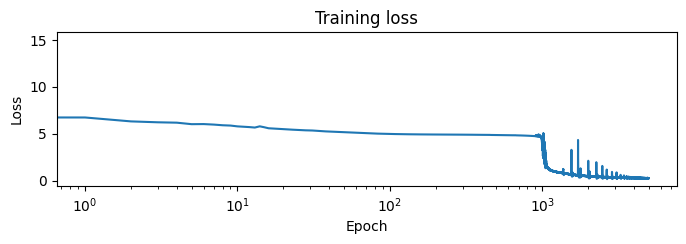

In [36]:
plt.figure(figsize=(8, 2))
plt.plot(total_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xscale('log')
plt.title('Training loss')
plt.show()

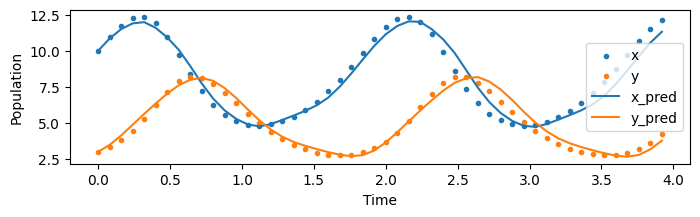

In [42]:
# Plot the results
y_pred = odeint(model, y0, ts, method='euler').detach()
plt.figure(figsize=(8, 2))
plt.scatter(ts.cpu().detach().numpy(), y_true[:,0].cpu().detach().numpy(), label='x', marker='.')
plt.scatter(ts.cpu().detach().numpy(), y_true[:,1].cpu().detach().numpy(), label='y', marker='.')
plt.plot(ts.cpu().detach().numpy(), y_pred[:,0].cpu().detach().numpy(), label='x_pred')
plt.plot(ts.cpu().detach().numpy(), y_pred[:,1].cpu().detach().numpy(), label='y_pred')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

In [38]:
true_model = LotkaVolterra().to(device)
y_dot_true = true_model(0, y_true)

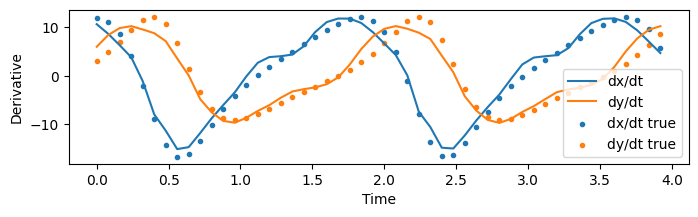

In [123]:
# Plot the derivatives
y_dot = model(ts, y_true)
plt.figure(figsize=(8, 2))
plt.plot(ts.cpu().detach().numpy(), y_dot[:,0].cpu().detach().numpy(), label='dx/dt')
plt.plot(ts.cpu().detach().numpy(), y_dot[:,1].cpu().detach().numpy(), label='dy/dt')
plt.scatter(ts.cpu().detach().numpy(), y_dot_true[:,0].cpu().detach().numpy(), label='dx/dt true', marker='.')
plt.scatter(ts.cpu().detach().numpy(), y_dot_true[:,1].cpu().detach().numpy(), label='dy/dt true', marker='.')
plt.xlabel('Time')
plt.ylabel('Derivative')
plt.legend()
plt.show()

### System Identification `pySINDy`


In [54]:
import pysindy as ps
import numpy as np

In [127]:
# Data from tensors to numpy
y_true_np = y_true.cpu().detach().numpy()
ts_np = ts.cpu().detach().numpy()
y0 = [10., 3.]
t = np.arange(0, 4, 0.08)

In [145]:
# Custum differentiation_method using trained NODE
def custom_diff(X, t):
    ts = torch.tensor(t, device=device)
    X = torch.tensor(X, device=device)
    y_dot = model(ts, X)
    return y_dot.cpu().detach().numpy()


In [152]:
si_model = ps.SINDy(differentiation_method=ps.SINDyDerivative(kind="spline", s=1e-2), feature_names=['x', 'y'])
print(si_model)

SINDy(differentiation_method=SINDyDerivative(kind='spline', s=0.01),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y'],
      optimizer=STLSQ())


In [153]:
si_model.fit(y_true_np, t=t)
si_model.print()

(x)' = 2.995 x + -0.599 x y
(y)' = -3.994 y + 0.499 x y


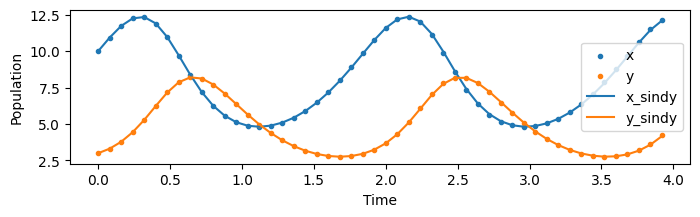

In [154]:
y_sindy = si_model.simulate(y0, t)

plt.figure(figsize=(8, 2))
plt.scatter(ts_np, y_true_np[:,0], label='x', marker='.')
plt.scatter(ts_np, y_true_np[:,1], label='y', marker='.')
plt.plot(t, y_sindy[:,0], label='x_sindy')
plt.plot(t, y_sindy[:,1], label='y_sindy')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()